# 전이 학습(+ Lenet34)

### - 기존 학습 모델의 가중치를 그대로 활용하거나 추가/업데이트하여 활용
### - 파인 튜닝은 포함되는 개념(Lora - 특정 부분만 재학습하여 사용)
### - 기존 학습의 분류가 만들려는 모델과 관계가 적을 경우, 전체 재학습이 나음(전이 학습x)

In [7]:
import os
import shutil

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

from tensorboardX import SummaryWriter
import tqdm

from PIL import Image

In [8]:
transforms_train = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]
)

transforms_test = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)


# torch가 자동으로 mapping(label 값을 생성)
# datasets
#   -train
#   -test
train_datasets = datasets.ImageFolder(root='../dataset/train', transform=transforms_train)
test_datasets = datasets.ImageFolder(root='../dataset/test', transform=transforms_test)
train_datasets

Dataset ImageFolder
    Number of datapoints: 24
    Root location: ../dataset/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [9]:
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=False)

In [10]:
next(iter(train_dataloader))

[tensor([[[[-1.3644, -1.3473, -1.3473,  ..., -1.6898, -1.7069, -1.7069],
           [-1.4158, -1.3473, -1.3130,  ..., -1.6727, -1.6898, -1.6898],
           [-1.4672, -1.3987, -1.3302,  ..., -1.6213, -1.6555, -1.6727],
           ...,
           [-1.7754, -1.7754, -1.7754,  ..., -1.8439, -2.0494, -2.0837],
           [-1.8097, -1.8268, -1.8097,  ..., -1.8439, -2.0494, -2.0837],
           [-1.8268, -1.8439, -1.8097,  ..., -1.8439, -2.0494, -2.0837]],
 
          [[-0.6527, -0.6001, -0.6001,  ..., -1.4055, -1.4230, -1.4230],
           [-0.7052, -0.6176, -0.5826,  ..., -1.3880, -1.3880, -1.3880],
           [-0.7752, -0.7052, -0.6527,  ..., -1.3004, -1.3354, -1.3880],
           ...,
           [-1.7381, -1.7381, -1.7556,  ..., -1.8256, -1.9657, -2.0007],
           [-1.7556, -1.7906, -1.7731,  ..., -1.8081, -1.9657, -2.0007],
           [-1.7731, -1.7906, -1.7731,  ..., -1.8081, -1.9657, -2.0007]],
 
          [[-1.0201, -1.0027, -0.9853,  ..., -1.2641, -1.3164, -1.2990],
           [-

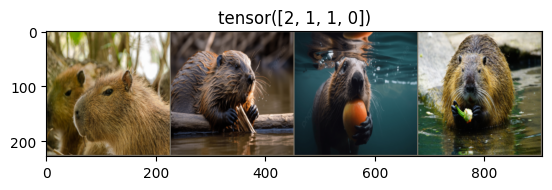

In [11]:
def imshow(img, title):
    
    img = img.numpy().transpose([1,2,0])
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    img = std * img + mean
    img = np.clip(img, 0, 1)
    
    plt.imshow(img)
    plt.title(title)
    plt.show()
    
images, labels = next(iter(train_dataloader))    
images_data = torchvision.utils.make_grid(images)

imshow(images_data, labels) # test할때 활용(배치 단위로 묶어서 화면 출력)

# 전이 모델로 예측

In [12]:
model = models.resnet34(pretrained=True) # 기존 모델 전이 학습(image-net 기반)
model

/Users/minwoojeon/J/Code/deep-learning/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/minwoojeon/J/Code/deep-learning/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/minwoojeon/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:01<00:00, 54.6MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
for param in model.layer1.parameters(): # 1번 레이어 동결
    param.requires_grad = False 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
#Layer freezing
for param in model.parameters(): 
    param.requires_grad = False # 모든 가중치 동결(frozen) : 업데이트 되지 않음 - 역전파 x

# Classifier custom
# (fc): Linear(in_features=512, out_features=1000, bias=True) => fc 이부분은 모델마다 다를 수 있으므로 확인
model.fc = nn.Linear(in_features=512, out_features=3) 
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

writer = SummaryWriter()

epochs = 10
step = 0

for epoch in range(epochs):
    for data, labels in tqdm.tqdm(train_dataloader):
        optimizer.zero_grad()
        preds = model(data.to(device))
        loss = criterion(preds, labels.to(device))
        writer.add_scalar('Loss/train', loss.item(), step)
        loss.backward()
        optimizer.step()
        step += 1
        
    print('loss', loss.item())    
    
# sci-kit learn이나 tensorboard로 학습 결과 측정 및 확인    

# tensorboard 조회
# tensorboard --logdir=theory/runs
# http://localhost:6006/?darkMode=true#timeseries

100%|██████████| 6/6 [00:00<00:00,  7.90it/s]


loss 0.48655784130096436


100%|██████████| 6/6 [00:00<00:00,  8.57it/s]


loss 0.49602562189102173


100%|██████████| 6/6 [00:00<00:00,  8.01it/s]


loss 0.2896345555782318


100%|██████████| 6/6 [00:00<00:00,  8.51it/s]


loss 0.5135606527328491


100%|██████████| 6/6 [00:00<00:00,  8.59it/s]


loss 0.22393199801445007


100%|██████████| 6/6 [00:00<00:00,  8.37it/s]


loss 0.3522767424583435


100%|██████████| 6/6 [00:00<00:00,  8.33it/s]


loss 0.4216863811016083


100%|██████████| 6/6 [00:00<00:00,  8.33it/s]


loss 0.41872161626815796


100%|██████████| 6/6 [00:00<00:00,  8.64it/s]


loss 1.6640353202819824


100%|██████████| 6/6 [00:00<00:00,  8.51it/s]

loss 0.4061543047428131


예측결과 : tensor([0, 0, 0, 1]), 정답: tensor([0, 0, 1, 1])


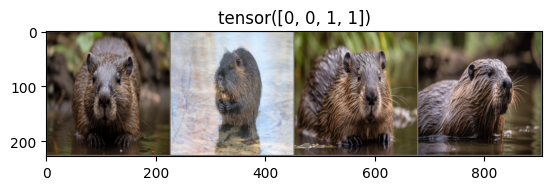

예측결과 : tensor([2, 1]), 정답: tensor([2, 2])


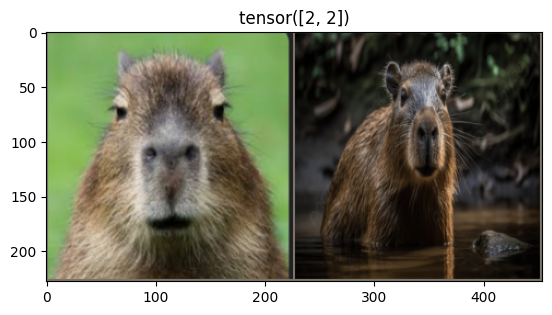

tensor(4)
최종 정확도 :  tensor(0.6667)


In [ ]:
model.eval()

total_pred = 0

with torch.no_grad():
    for data, label in test_dataloader:
        pred = model(data.to(device)) 
        
        pred = torch.max(pred, 1)[1] # [0, 1, 1, 2]
        
        total_pred = total_pred + torch.sum(pred==label.to(device).data)
        
        print(f'예측결과 : {pred}, 정답: {label}')
        images_data = torchvision.utils.make_grid(data)
        imshow(images_data.to('cpu'), label)

print(total_pred)        
print('최종 정확도 : ', total_pred/len(test_datasets))

In [ ]:
# 정확도가 낮게 나오는 경우
# 1. Data 확인 
# 2. freeze된 model을 해동 후 다시 가진 Data로 재학습

In [21]:
image = Image.open('../data/ca.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

result = model(image)
torch.max(result, 1)

torch.return_types.max(
values=tensor([1.6866], grad_fn=<MaxBackward0>),
indices=tensor([2]))

In [24]:
# 가중치만 저장(실무에서 주로 사용하는 형태)
torch.save(model.state_dict(), '../pth/celeb_model_weight.pth') # 딥러닝 저장법(머신러닝은 joblib)

In [25]:
# 모델의 전체 저장(가중치 + 구조)
torch.save(model, '../pth/celeb_model_total.pth')